In [2]:
from multiprocessing import Pool
import tqdm
import pickle
from pathlib import Path
from contextlib import closing
from rdkit import Chem
import numpy as np
import pandas as pd

In [3]:
import sys
sys.path.append("../")

In [4]:
%%time
fragments_path = Path("/net/cci/cschlick/Filtered_COD3/fragments.pkl")
with fragments_path.open("rb") as fh:
  fragments = pickle.load(fh)

CPU times: user 27.6 s, sys: 3.28 s, total: 30.9 s
Wall time: 31.1 s


In [5]:
N_max = 1000
angle_fragments = []
bond_fragments = []
for i,result in enumerate(fragments):
  if i<N_max or N_max == -1:
    angle_fragments+=result["angle_fragments"]
    bond_fragments+=result["bond_fragments"]

In [6]:
from phenixml.featurizers.bond_angle_tokenizer import BondTokenizer, AngleTokenizer, bond_order

In [7]:
def worker_angle(angle_fragment):
  angle_tokenizer = AngleTokenizer(ignore_bond_type=False)
  return angle_tokenizer.featurize(angle_fragment)

def worker_bond(bond_fragment):
  bond_tokenizer = BondTokenizer(ignore_bond_type=False)
  return bond_tokenizer.featurize(bond_fragment)

In [8]:
bond_tokenizer = BondTokenizer(ignore_bond_type=False)

In [9]:
work = angle_fragments
with closing(Pool(processes=32)) as pool:
  angle_tokens = []
  for result in tqdm.tqdm(pool.map(worker_angle, work), total=len(work)):
      angle_tokens.append(result)
  pool.terminate()

100%|██████████| 48082/48082 [00:00<00:00, 2516320.73it/s]


In [10]:
work = bond_fragments
with closing(Pool(processes=16)) as pool:
  bond_tokens = []
  for result in tqdm.tqdm(pool.map(worker_bond, work), total=len(work)):
      bond_tokens.append(result)
  pool.terminate()

100%|██████████| 32949/32949 [00:00<00:00, 1235058.65it/s]


In [11]:
covalent_organic = ["O","C","H","N","P","S","Cl","B","F","I","Br","None"]

periodic_table_symbol_keys = {"H": 1, "He": 2, "Li": 3, "Be": 4, "B": 5,
                            "C": 6, "N": 7, "O": 8, "F": 9, "Ne": 10,
                            "Na": 11, "Mg": 12, "Al": 13, "Si": 14, "P": 15,
                            "S": 16, "Cl": 17, "Ar": 18, "K": 19, "Ca": 20,
                            "Sc": 21, "Ti": 22, "V": 23, "Cr": 24, "Mn": 25,
                            "Fe": 26, "Co": 27, "Ni": 28, "Cu": 29,
                            "Zn": 30, "Ga": 31, "Ge": 32, "As": 33,
                            "Se": 34, "Br": 35, "Kr": 36, "Rb": 37,
                            "Sr": 38, "Y": 39, "Zr": 40, "Nb": 41, "Mo": 42,
                            "Tc": 43, "Ru": 44, "Rh": 45, "Pd": 46,
                            "Ag": 47, "Cd": 48, "In": 49, "Sn": 50,
                            "Sb": 51, "Te": 52, "I": 53, "Xe": 54, "Cs": 55,
                            "Ba": 56, "La": 57, "Ce": 58, "Pr": 59,
                            "Nd": 60, "Pm": 61, "Sm": 62, "Eu": 63,
                            "Gd": 64, "Tb": 65, "Dy": 66, "Ho": 67,
                            "Er": 68, "Tm": 69, "Yb": 70, "Lu": 71,
                            "Hf": 72, "Ta": 73, "W": 74, "Re": 75, "Os": 76,
                            "Ir": 77, "Pt": 78, "Au": 79, "Hg": 80,
                            "Tl": 81, "Pb": 82, "Bi": 83, "Po": 84,
                            "At": 85, "Rn": 86, "Fr": 87, "Ra": 88,
                            "Ac": 89, "Th": 90, "Pa": 91, "U": 92, "Np": 93,
                            "Pu": 94, "Am": 95, "Cm": 96, "Bk": 97,
                            "Cf": 98, "Es": 99, "Fm": 100, "Md": 101,
                            "No": 102, "Lr": 103, "Rf": 104, "Db": 105,
                            "Sg": 106, "Bh": 107, "Hs": 108, "Mt": 109,
                            "Ds": 110, "Rg": 111, "Cn": 112, "Nh": 113,
                            "Fl": 114, "Mc": 115, "Lv": 116, "Ts": 117,
                            "Og": 118}


periodic_table_number_keys = {value: key for key, value in periodic_table_symbol_keys.items()}

In [12]:
from itertools import combinations
combs = list(combinations(covalent_organic,4))

In [13]:
#from phenixml.utils.rdkit_utils import periodic_table_number_keys, periodic_table_symbol_keys

In [14]:
front_side_tokens = []
back_side_tokens = []
for i,frag in enumerate(bond_fragments):
  front_side = []
  front_side_bonds = []
  back_side = []
  back_side_bonds = []

  atom_indices = [x for _, x in sorted(zip(frag.atom_numbers,frag.atom_indices))]
  aidx = atom_indices[0]
  atom = frag.rdmol.GetAtomWithIdx(aidx)
  nbrs = atom.GetNeighbors()
  for nbr in nbrs:
    nidx = nbr.GetIdx()
    if nbr not in atom_indices:
      if len(front_side)<4:
        front_side.append(nbr.GetSymbol())
        bond = frag.rdmol.GetBondBetweenAtoms(aidx,nidx)
        bondo = bond_order(bond.GetBondType())
        front_side_bonds.append(bondo)

  aidx = atom_indices[-1]
  atom = frag.rdmol.GetAtomWithIdx(aidx)
  nbrs = atom.GetNeighbors()
  for nbr in nbrs:
    nidx = nbr.GetIdx()
    if nidx not in atom_indices:
      if len(back_side)<4:
        back_side.append(nbr.GetSymbol())
        bond = frag.rdmol.GetBondBetweenAtoms(aidx,nidx)
        bondo = bond_order(bond.GetBondType())
        back_side_bonds.append(bondo)

  for i in range(4-len(front_side)):
    front_side.append("None")
    front_side_bonds.append(0)
  for i in range(4-len(back_side)):
    back_side.append("None")
    back_side_bonds.append(0)

  front_side_numbers = [periodic_table_symbol_keys[s] if s in periodic_table_symbol_keys.keys() else -1 for s in front_side]
  back_side_numbers = [periodic_table_symbol_keys[s] if s in periodic_table_symbol_keys.keys() else -1 for s in back_side]
  front_side = [x for _, x in sorted(zip(front_side_numbers,front_side))]
  front_side_bonds = [x for _, x in sorted(zip(front_side_numbers,front_side_bonds))]
  
  back_side = [x for _, x in sorted(zip(back_side_numbers,back_side))]
  back_side_bonds = [x for _, x in sorted(zip(back_side_numbers,back_side_bonds))]
  assert(len(front_side)==4)
  assert(len(back_side)==4)
  front_side_tokens.append(front_side+front_side_bonds)
  back_side_tokens.append(back_side+back_side_bonds)

In [15]:
bond_tokens_fat = []
for i,tok in enumerate(bond_tokens):
  fs,bs = front_side_tokens[i],back_side_tokens[i]
  t = fs+tok+bs
    
  bond_tokens_fat.append(t)

In [16]:
tokens = np.array(bond_tokens_fat)

In [16]:
bond_tokens2 = np.array(bond_tokens)
print(bond_tokens2.shape)
bond_tokens1 = np.vstack([bond_tokens2[:,0],bond_tokens2[:,2]]).T
print(bond_tokens1.shape)

(1856810, 3)


In [52]:
angle_tokens2 = np.array(angle_tokens)
print(angle_tokens2.shape)
angle_tokens1 = np.vstack([angle_tokens2[:,0],angle_tokens2[:,2],angle_tokens2[:,4]]).T
print(angle_tokens1.shape)

(2657850, 5)
(2657850, 3)


In [17]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(tokens)
print(encoder.categories_)
X = encoder.transform(tokens)
print(X.shape)

[array(['B', 'Br', 'C', 'F', 'H', 'N', 'None', 'O'], dtype='<U4'), array(['B', 'Br', 'C', 'Cl', 'F', 'H', 'N', 'None', 'O'], dtype='<U4'), array(['B', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'None', 'O', 'P', 'S'],
      dtype='<U4'), array(['Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S'], dtype='<U4'), array(['0', '1'], dtype='<U4'), array(['0', '1', '2', '4'], dtype='<U4'), array(['0', '1', '2', '3', '4'], dtype='<U4'), array(['1', '2', '3', '4'], dtype='<U4'), array(['B', 'C', 'F', 'I', 'N', 'O', 'P', 'S'], dtype='<U4'), array(['1', '2', '3', '4'], dtype='<U4'), array(['B', 'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S'], dtype='<U4'), array(['F', 'None'], dtype='<U4'), array(['B', 'C', 'Cl', 'F', 'H', 'N', 'None', 'O'], dtype='<U4'), array(['B', 'C', 'Cl', 'F', 'H', 'N', 'None', 'O', 'P', 'S'], dtype='<U4'), array(['B', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'None', 'O', 'P', 'S'],
      dtype='<U4'), array(['0', '1'], dtype='<U4'), array(['0', '1'], dtype='<U4'), array(['0', '1', '2', '4

In [18]:
# reverse_check = encoder.inverse_transform(X)
# assert(np.all(tokens==reverse_check))

In [19]:
#y =  np.array([frag.properties["angle_deg"] for frag in angle_fragments])
y =  np.array([frag.properties["bond_length"] for frag in bond_fragments])

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [21]:
# frags_train, frags_test = [angle_fragments[i] for i in train], [angle_fragments[i] for i in test]
# X_train, X_test = X[train],X[test]
# y_train, y_test = y[train],y[test]
space = np.arange(X.shape[0])
train, test = train_test_split(space,test_size=0.2)
frags_train, frags_test = [bond_fragments[i] for i in train], [bond_fragments[i] for i in test]
#frags_train, frags_test = [angle_fragments[i] for i in train], [angle_fragments[i] for i in test]
tokens_train, tokens_test = tokens[train], tokens[test]
X_train, X_test = X[train],X[test]
y_train, y_test = y[train],y[test]

In [22]:
# from numpy import mean
# from numpy import std
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestClassifier
# from matplotlib import pyplot
 

  
# # get a list of models to evaluate
# def get_models():
#   models = dict()
#   # define number of trees to consider
#   n_trees = [10, 50, 100, 500, 1000]
#   for n in n_trees:
#     models[str(n)] = RandomForestRegressor(n_estimators=n,min_samples_split=2, random_state=0,n_jobs=-1)
#   return models
 
# # get the models to evaluate
# models = get_models()
# for key,model in models.items():
#   model.fit(X_train,y_train)
# # evaluate the models and store results
# results, names = list(), list()
# for name, model in models.items():
#   # evaluate the model
#   #scores = cross_val_score(model, X_train, y_train, scoring="r2",n_jobs=-1)
#   scores = cross_val_score(model, X_test,y_test,scoring="r2",n_jobs=-1)
#   # store the results
#   results.append(scores)
#   names.append(name)
#   # summarize the performance along the way
#   print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# # plot model performance for comparison
# pyplot.boxplot(results, labels=names, showmeans=True)
# pyplot.show()

In [23]:
regressor = RandomForestRegressor(n_estimators=100,min_samples_split=2, random_state=0,n_jobs=-1)

In [24]:
%%time
regressor.fit(X_train,y_train)

CPU times: user 40.7 s, sys: 291 ms, total: 41 s
Wall time: 1.18 s


RandomForestRegressor(n_jobs=-1, random_state=0)

In [25]:
y_pred = regressor.predict(X_test)

Text(0, 0.5, 'Predicted')

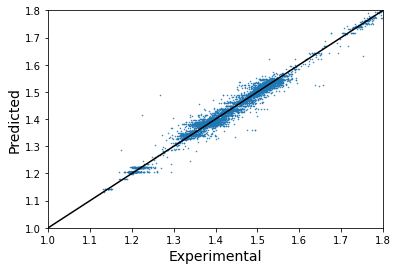

In [26]:
mode = "bond"
df = pd.DataFrame({"dists":y_test.flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)

In [29]:
export_graphviz

NameError: name 'export_graphviz' is not defined

In [31]:


# Model (can also use single decision tree)
model = regressor
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])



NameError: name 'iris' is not defined

In [32]:
from sklearn.tree import export_text

In [36]:
estimator = regressor.estimators_[5]
print(export_text(estimator))

|--- feature_61 <= 0.50
|   |--- feature_103 <= 0.50
|   |   |--- feature_74 <= 0.50
|   |   |   |--- feature_59 <= 0.50
|   |   |   |   |--- feature_48 <= 0.50
|   |   |   |   |   |--- feature_73 <= 0.50
|   |   |   |   |   |   |--- feature_63 <= 0.50
|   |   |   |   |   |   |   |--- feature_53 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_71 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_119 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_100 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |   |   |   |   |   |--- feature_100 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |--- feature_119 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_30 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |   |--- feature_30 >  0.50
|   |   |   |   |   |   |  

In [27]:
residuals = y_test-y_pred

In [28]:
sns.histplot(residuals)

NameError: name 'sns' is not defined

In [ ]:
from phenixml.utils.eval_utils import tukey_test
outliers_prob,outliers_poss = tukey_test(residuals)
print(len(outliers_poss),(len(outliers_poss)/len(y_test))*100)
print(len(outliers_prob),(len(outliers_prob)/len(y_test))*100)

Text(0, 0.5, 'Predicted')

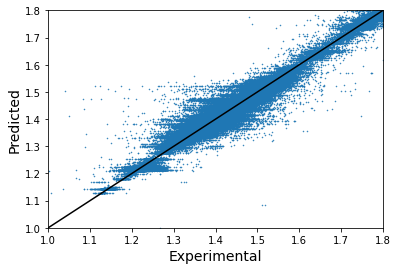

In [198]:
mode = "bond"
df = pd.DataFrame({"dists":y_test.flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)

Text(0, 0.5, 'Predicted')

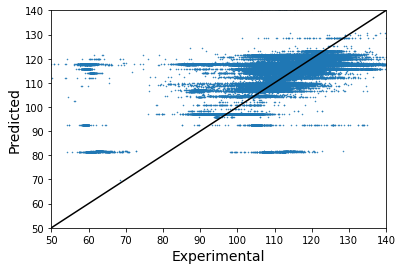

In [72]:
mode = "angle"
df = pd.DataFrame({"dists":y_test.flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)

Text(0, 0.5, 'Predicted')

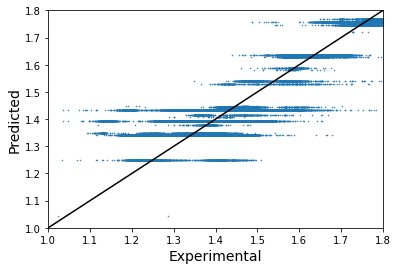

In [35]:
mode = "bond"
df = pd.DataFrame({"dists":y_test.flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)

In [132]:
cross_val_score(regressor, X_test,y_test,scoring="r2",n_jobs=-1)

array([0.58598385, 0.57785496, 0.56124521, 0.59287806, 0.57086378])

In [133]:
tokens

array([['C', 'O'],
       ['C', 'N'],
       ['C', 'N'],
       ...,
       ['C', 'C'],
       ['C', 'C'],
       ['C', 'C']], dtype='<U2')

Text(0, 0.5, 'Predicted')

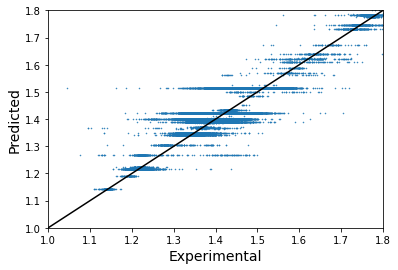

In [87]:
mode = "bond"
df = pd.DataFrame({"dists":y_test.flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)

In [86]:
from sklearn.metrics import mean_squared_error
import seaborn as sns

<AxesSubplot:ylabel='Count'>

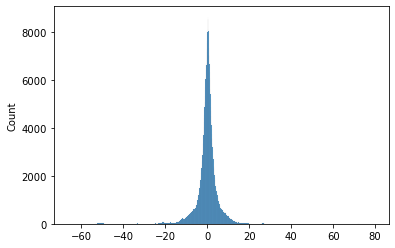

In [87]:
sns.histplot(y_test-y_pred)

In [88]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE:",rmse)

RMSE: 5.552888532264999


In [110]:
error = np.sqrt((y_test-y_pred)**2)

In [111]:
sorted_error = np.flip(np.argsort(error))

In [116]:
sorted_error

array([ 596,  352,  986, ...,  279,  579, 1152])

In [117]:
i = sorted_error[20]
frag = frags_test[i]
print(encoder.inverse_transform(X_test[i]))
print(tokens_test[i])
print(error[i])
print(y_test[i],y_pred[i])
print()

[['C' '1' 'C']]
['C' '1' 'C']
0.2783308842534993
1.2220201918363092 1.5003510760898084



In [119]:
bond_tokenizer.featurize(frag)

['N', '2', 'O']

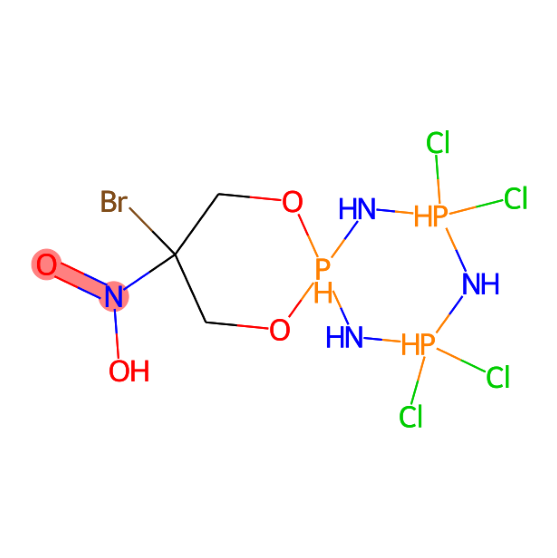

In [114]:
frag.show(only_connected=False)

In [355]:
encoder.transform?

/net/cci/cschlick/Software/miniconda3/envs/cod_validation/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Signature: encoder.transform(X)
Docstring:
Transform X using one-hot encoding.

Parameters
----------
X : array-like, shape [n_samples, n_features]
    The data to encode.

Returns
-------
X_out : sparse matrix if sparse=True else a 2-d array
    Transformed input.
File:      ~/Software/miniconda3/envs/cod_validation/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py
Type:      method


In [356]:
encoder.inverse_transform(X_test[i])

/net/cci/cschlick/Software/miniconda3/envs/cod_validation/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([['C', '4', 'C']], dtype=object)

In [357]:
labels_check = encoder.inverse_transform(X_test)

In [360]:
bond_tokens2[test[i]]

/net/cci/cschlick/Software/miniconda3/envs/cod_validation/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['C', '4', 'C'], dtype='<U2')

In [358]:
labels_check

/net/cci/cschlick/Software/miniconda3/envs/cod_validation/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([['C', '1', 'C'],
       ['O', '1', 'S'],
       ['C', '1', 'O'],
       ...,
       ['C', '1', 'N'],
       ['C', '4', 'C'],
       ['C', '4', 'C']], dtype=object)

Text(0, 0.5, 'Predicted')

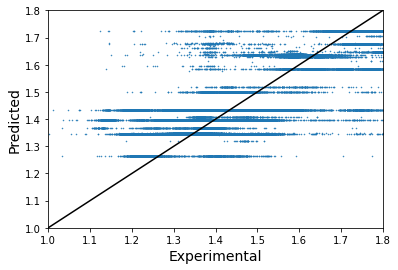

In [298]:
mode = "bond"
df = pd.DataFrame({"dists":y_test.flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)